<a href="https://colab.research.google.com/github/eliasd/speedpred/blob/master/CommaSpeedPrediction_v3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd drive/My\ Drive/Creative/speedpred

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Creative/speedpred


In [ ]:
! git fetch origin master
! git reset --hard FETCH_HEAD
! git clean -df

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/eliasd/speedpred
 * branch            master     -> FETCH_HEAD
   e3b8957..1ed1612  master     -> origin/master
HEAD is now at 1ed1612 Reset image ratio


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

from dataset import get_pre_processed_dataset

### Getting the dataset

#### - Option #1: Shuffle the entire dataset, then select the train / val / test datasets.

In [ ]:
# Dataset size:
# if window_size = 4, then 5100 elements.
ds = get_pre_processed_dataset().cache('./cache/').prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Most of the time in this cell is spent counting 
# the number of elements in the dataset.
DS_SIZE = sum(1 for _ in ds)
print(f'Number of elements: {DS_SIZE}')

train_size = int(0.7 * DS_SIZE)
val_size = int(0.15 * DS_SIZE)
test_size = int(0.15 * DS_SIZE)
print(f'Train size: {train_size}')
print(f'Validation size: {val_size}')
print(f'Test size: {test_size}')

# Shuffle dataset.
ds = ds.shuffle(buffer_size=DS_SIZE)

# Get training set.
train_ds = ds.take(train_size)

# Get validation and test sets.
full_test_ds = ds.skip(train_size)
val_ds = full_test_ds.take(val_size)
test_ds = full_test_ds.skip(test_size)

## TODO:
# - experiment with different tools (prefetch, cache) to speed up tf.data pipeline
#   performance
# - figure out how to program model training "restarts" (hypothesis: this 
#   is what lead to the sharp drop in loss from epoch 8 to epoch 9)
# - Create some cool graphs: (1) mse loss vs. epoch, (2) groundtruth test speed & pred 
#     test speed vs. test frame number,

Number of elements: 5100
Train size: 3570
Validation size: 765
Test size: 765


#### - Option #2: Select the last 15% of the dataset as the test set; then shuffle & select validation & train sets.

In [ ]:
# Dataset size:
# if window_size = 4, then 5100 elements.
# 
# Note: we add the .cache and .prefetch calls to improve datapipeline performance.
ds = get_pre_processed_dataset().cache('./cache/').prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Most of the time in this cell is spent counting 
# the number of elements in the dataset.
DS_SIZE = sum(1 for _ in ds)
print(f'Number of elements: {DS_SIZE}')

train_size = int(0.7 * DS_SIZE)
val_size = int(0.15 * DS_SIZE)
train_and_val_size = int(0.85 * DS_SIZE)
test_size = int(0.15 * DS_SIZE)

print(f'Train size: {train_size}')
print(f'Validation size: {val_size}')
print(f'Training & Validation size: {train_and_val_size}')
print(f'Test size: {test_size}')


# Get training & validation set, shuffle it, and split it.
train_and_val_orig_ds = ds.take(train_and_val_size)
train_and_val_ds = train_and_val_orig_ds.shuffle(buffer_size=train_and_val_size)
train_ds = train_and_val_ds.take(train_size)
val_ds = train_and_val_ds.skip(train_size)

# Get test set.
test_ds = ds.skip(train_and_val_size)

Number of elements: 5100
Train size: 3570
Validation size: 765
Training & Validation size: 4335
Test size: 765


### -- Fitting the Model

In [ ]:
def get_speed_prediction_network(output_window_size=4):
    return SpeedPredictionNetwork(output_window_size)

class SpeedPredictionNetwork(tf.keras.Model):
    def __init__(self, output_window_size):
        super(SpeedPredictionNetwork, self).__init__()

        initializer = tf.initializers.VarianceScaling(scale=2.0)

        # Layer #1: Padding + Convolution + Batch Normalization + Relu + Dropout.
        self.conv_h1 = tf.keras.layers.Conv2D(filters=24, 
                                              kernel_size=5, 
                                              padding='same',
                                              kernel_initializer=initializer,
                                              kernel_regularizer='l2')
        self.bn_h1 = tf.keras.layers.LayerNormalization()
        self.relu_h1 = tf.keras.layers.ReLU()
        self.drop_h1 = tf.keras.layers.Dropout(0.40)
        
        # Layer #2: Padding + Convolution + Batch Normalization + RelU + Dropout.
        self.conv_h2 = tf.keras.layers.Conv2D(filters=36, 
                                              kernel_size=3,
                                              padding='same',
                                              kernel_initializer=initializer,
                                              kernel_regularizer='l2')
        self.bn_h2 = tf.keras.layers.LayerNormalization()
        self.relu_h2 = tf.keras.layers.ReLU()
        self.drop_h2 = tf.keras.layers.Dropout(0.40)

        # Layer #3: Max-Pool
        self.maxPool_h3 = tf.keras.layers.MaxPool2D()

        # Layer #4: Padding + Convolution + Batch Normalization + ReLU + Dropout.
        self.conv_h4 = tf.keras.layers.Conv2D(filters=48,
                                               kernel_size=3,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               kernel_regularizer='l2')
        self.bn_h4 = tf.keras.layers.LayerNormalization()
        self.relu_h4 = tf.keras.layers.ReLU()
        self.drop_h4 = tf.keras.layers.Dropout(0.40)

        # Layer #5: Padding + Convolution + Batch Normalization + ReLu + Dropout.
        self.conv_h5 = tf.keras.layers.Conv2D(filters=64,
                                               kernel_size=3,
                                               padding='same',
                                               kernel_initializer=initializer,
                                               kernel_regularizer='l2')
        self.bn_h5 = tf.keras.layers.LayerNormalization()
        self.relu_h5 = tf.keras.layers.ReLU()
        self.drop_h5 = tf.keras.layers.Dropout(0.40)

        # Flatten.
        self.flatten = tf.keras.layers.Flatten()

        # Layer #6: Fully-Connected + ReLU + Batch Normalization + Dropout.
        self.fc_h6 = tf.keras.layers.Dense(256, kernel_initializer=initializer, kernel_regularizer='l2')
        self.bn_h6 = tf.keras.layers.LayerNormalization()
        self.relu_h6 = tf.keras.layers.ReLU()
        self.drop_h6 = tf.keras.layers.Dropout(0.40)

        # Layer #7: Fully-Connected + ReLU + Batch Normalization + Dropout.
        self.fc_h7 = tf.keras.layers.Dense(256, kernel_initializer=initializer, kernel_regularizer='l2')
        self.bn_h7 = tf.keras.layers.LayerNormalization()
        self.relu_h7 = tf.keras.layers.ReLU()
        self.drop_h7 = tf.keras.layers.Dropout(0.40)
 
        # Layer #8: Fully-Connected ==> Regression output of size output_window_size.
        self.fc_h8 = tf.keras.layers.Dense(output_window_size,
                                           kernel_initializer=initializer,
                                           kernel_regularizer='l2')
    
    def call(self, input_tensor, training=False):
        # Layer #1.
        h1 = self.conv_h1(input_tensor)
        h1 = self.bn_h1(h1, training=training)
        h1 = self.relu_h1(h1)
        h1 = self.drop_h1(h1, training=training)

        # Layer #2.
        h2 = self.conv_h2(h1)
        h2 = self.bn_h2(h2, training=training)
        h2 = self.relu_h2(h2)
        h2 = self.drop_h2(h2, training=training)

        # Layer #3.
        h3 = self.maxPool_h3(h2)

        # Layer #4
        h4 = self.conv_h4(h3)
        h4 = self.bn_h4(h4, training=training)
        h4 = self.relu_h4(h4)
        h4 = self.drop_h4(h4, training=training)

        # Layers #5.
        h5 = self.conv_h5(h4)
        h5 = self.bn_h5(h5, training=training)
        h5 = self.relu_h5(h5)
        h5 = self.drop_h5(h5, training=training)

        # Layer #6.
        h6 = self.flatten(h5)
        h6 = self.fc_h6(h6)
        h6 = self.bn_h6(h6, training=training)
        h6 = self.relu_h6(h6)
        h6 = self.drop_h6(h6, training=training)

        # Layer #7.
        h7 = self.fc_h7(h6)
        h7 = self.bn_h7(h7, training=training)
        h7 = self.relu_h7(h7)
        h7 = self.drop_h7(h7, training=training)

        # Layer #5.
        x = self.fc_h8(h7)
        
        return x

In [ ]:
model = get_speed_prediction_network()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='mse',
              metrics=['mse'])

history = model.fit(train_and_val_ds.batch(9), epochs=9)

Epoch 1/9
482/482 [==============================] - 251s 521ms/step - loss: 118.3915 - mse: 106.8457
Epoch 2/9
482/482 [==============================] - 251s 520ms/step - loss: 81.2934 - mse: 72.9305
Epoch 3/9
482/482 [==============================] - 251s 520ms/step - loss: 76.7808 - mse: 70.2340
Epoch 4/9
482/482 [==============================] - 251s 521ms/step - loss: 67.6469 - mse: 59.6005
Epoch 5/9
482/482 [==============================] - 251s 520ms/step - loss: 29.6848 - mse: 19.2452
Epoch 6/9
482/482 [==============================] - 250s 519ms/step - loss: 21.2248 - mse: 11.7825
Epoch 7/9
482/482 [==============================] - 251s 520ms/step - loss: 17.7103 - mse: 8.4939
Epoch 8/9
482/482 [==============================] - 251s 520ms/step - loss: 15.4716 - mse: 6.4830
Epoch 9/9
482/482 [==============================] - 251s 520ms/step - loss: 13.8714 - mse: 5.6152


## -- Evaluating the Model

#### MSE training history (MSE vs. epoch)

In [ ]:
print(f"Keys of history: {history.history.keys()}")

Keys of history: dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


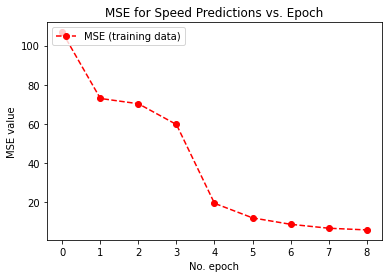

In [ ]:
# Plot history: MSE
plt.plot(history.history['mse'], 'ro--', label='MSE (training data)')
#plt.plot(history.history['val_mse'], 'bo--', label='MSE (validation data)')
plt.title('MSE for Speed Predictions vs. Epoch')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#### MSE on the test dataset.

In [ ]:
model.evaluate(test_ds.batch(5))

153/153 [==============================] - 59s 384ms/step - loss: 25.5372 - mse: 17.5243


[25.537160873413086, 17.524282455444336]

### Entire dataset

In [ ]:
ds_groundtruth_speed = []
for window, labels in ds:
  ds_groundtruth_speed.extend(labels.numpy().tolist())

ds_image_indexes = list(range(len(ds_groundtruth_speed)))

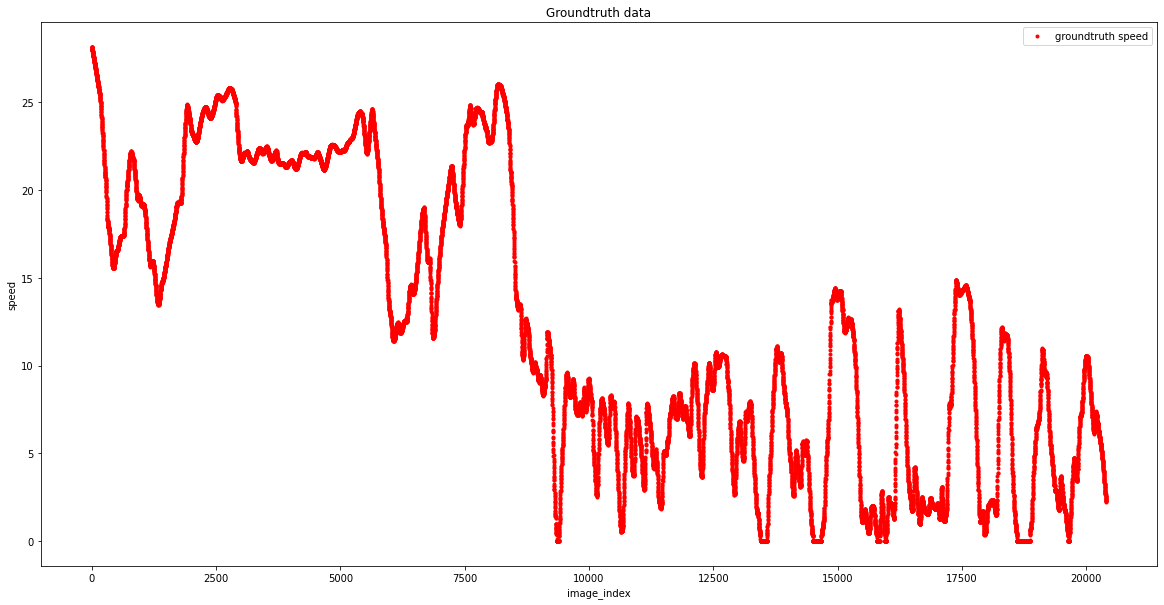

In [ ]:
# Plot groundtruth speed timeseries
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(ds_image_indexes, ds_groundtruth_speed, 'r.')
plt.xlabel('image_index')
plt.ylabel('speed')
plt.title('Groundtruth data')
plt.legend(['groundtruth speed'], loc='upper right')
plt.show()
plt.close()

#### Predicted Speed vs. Groundtruth on train-and-val dataset.

In [ ]:
trainval_groundtruth_speed = []
trainval_predicted_speed = []
for window, labels in train_and_val_orig_ds:
  preds = model(tf.expand_dims(window, 0))

  trainval_groundtruth_speed.extend(labels.numpy().tolist())
  trainval_predicted_speed.extend(preds.numpy()[0].tolist())

trainval_image_indexes = list(range(len(trainval_groundtruth_speed)))

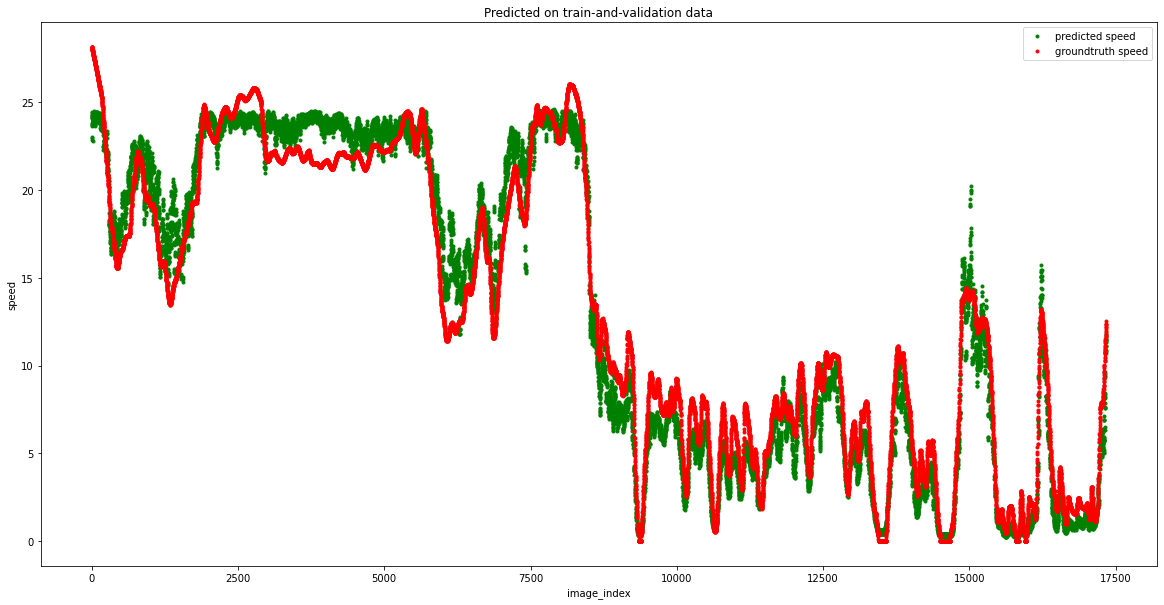

In [ ]:
# Plot predicted speed vs. groundtruth.
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(trainval_image_indexes, trainval_predicted_speed, 'g.')
plt.plot(trainval_image_indexes, trainval_groundtruth_speed, 'r.')
plt.xlabel('image_index')
plt.ylabel('speed')
plt.title('Predicted on train-and-validation data')
plt.legend(['predicted speed', 'groundtruth speed'], loc='upper right')
plt.show()
plt.close()

#### Predicted Speed vs. Groundtruth on test dataset.

In [ ]:
test_groundtruth_speed = []
test_predicted_speed = []
for window, labels in test_ds:
  preds = model(tf.expand_dims(window, 0))

  test_groundtruth_speed.extend(labels.numpy().tolist())
  test_predicted_speed.extend(preds.numpy()[0].tolist())

image_indexes = list(range(len(test_groundtruth_speed)))

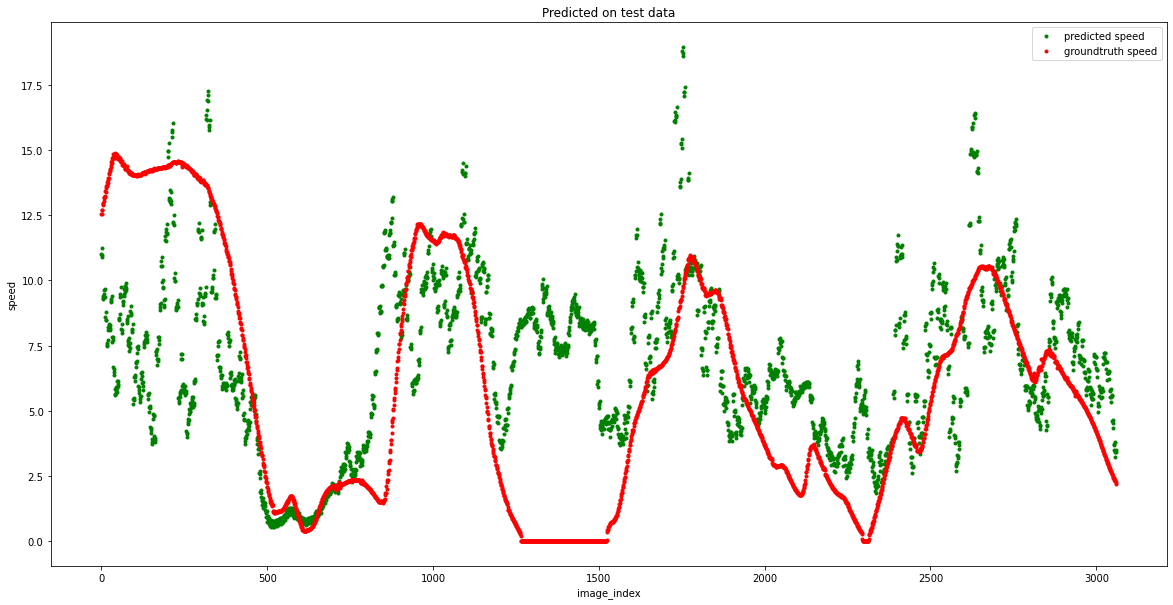

In [ ]:
# Plot predicted speed vs. groundtruth.
#
# Looking at the results below, it seems like the model doesn't have enough data
# to generalize well under the given model. Does especially bad under the zero 
# velocity case.

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(image_indexes, test_predicted_speed, 'g.')
plt.plot(image_indexes, test_groundtruth_speed, 'r.')
plt.xlabel('image_index')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['predicted speed', 'groundtruth speed'], loc='upper right')
plt.show()
plt.close()